In [1]:
# =================================================================================
# 1-1. Library Import 
# =================================================================================
import os
import copy
import random
import time
import io
import contextlib
import glob
import re

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# fvcore (optional)
try:
    from fvcore.nn import FlopCountAnalysis
    FVCORE_AVAILABLE = True
except Exception:
    FlopCountAnalysis = None
    FVCORE_AVAILABLE = False

In [2]:
# =================================================================================
# 1-2. Define CONFIG 
# =================================================================================

CONFIG = {
    # ---------------------------
    # Reproducibility / Experiment ID
    # ---------------------------
    "seed": 42,
    "dataset_name": "PAMAP2",

    # ---------------------------
    # Data / Split
    # ---------------------------
    "data_dir": "C://Users/park9/CBAM_HAR/PAMAP2", 
    "train_subject_ratio": 0.6,
    "val_subject_ratio": 0.2,

    "batch_size": 128,  # dataloader

    "window_size": 128,
    "step_size": 64,

    # ---------------------------
    # Training
    # ---------------------------
    "epochs": 100,
    "learning_rate": 5e-4,
    "weight_decay": 1e-4,
    "contrast_weight": 0.25,  # total_loss = CE + contrast_weight * contrast_loss
    "scheduler_type": "cosine", # scheduler (CosineAnnealingLR)
    "scheduler_T_max": 100,  # CosineAnnealingLR(T_max=EPOCHS)

    # ---------------------------
    # Model architecture (PAMAP2)
    # ---------------------------
    "in_channels": 36,        # 9 inertial signals (acc/gyro/total xyz)
    "seq_len": 128,          # window length
    "n_classes": 12,          # HAR classes
    "n_prototypes": 12,       # prototype counts

    "embed_dim": 64,         # Conv1d -> Transformer base dim
    "reduced_dim": 32,       # if we use_dim_reduction == True
    "use_dim_reduction": False,

    "n_heads": 8,            # multi-head attention heads in CrossFormer block
    "dropout": 0.1,

    "kernel_size": 7,       # kernel sizes used in Conv1d embedding and CBAM temporal attention

    # ---------------------------
    # Feature toggles (ablations)
    # ---------------------------
    "use_cbam": True,        # CBAM
    "use_crossformer": True, # CrossFormerBlock
    "use_contrast": True,    # include contrastive prototype loss during training

    # ---------------------------
    # Contrast / Prototype behavior
    # ---------------------------
    "temperature": 0.05,     # temperature in contrastive loss

    # ---------------------------
    # Logging / Debug convenience
    # ---------------------------
    "print_every": 25,        # print every or bumped epoch
    "do_tsne": True,        # t-SNE
    "profile_model": True,  # FLOPs / Params
}

def pretty_print_config(cfg: dict):
    print("=" * 80)
    print("EXPERIMENT CONFIG")
    print("-" * 80)
    # key alignment
    max_k = max(len(k) for k in cfg.keys())
    for k in sorted(cfg.keys()):
        print(f"{k.ljust(max_k)} : {cfg[k]}")
    print("=" * 80)

In [3]:
# =================================================================================
# 1-3. Reproducibility helpers
# =================================================================================
def seed_everything(seed: int = 42):
    """
    Fix random seeds for reproducibility across random, numpy, torch (cpu & cuda).
    Also configures CuDNN for deterministic behavior.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # cudnn deterministic mode: reproducible but may be slower
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def seed_worker(worker_id: int):
    """
    To make DataLoader workers deterministic.
    """
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [4]:
def create_pamap2_windows(df: pd.DataFrame, window_size: int, step_size: int):
    """
    subject별로 timestamp 순서대로 전체 시계열을 따라가며 슬라이딩 윈도우 생성.
    한 윈도우의 라벨은 마지막 프레임의 activityID.
    마지막 라벨이 0(Null/기타) 이면 그 윈도우는 버린다.

    Returns:
        X:          (N, C, T) float32
        y:          (N,) int64  (0..11로 리맵된 레이블)
        subj_ids:   (N,) int64
        label_names:list[str] 길이 12, new_index -> human-readable
    """

    # 사용할 피처들 (orientation*, heartrate, *_Temperature 등은 제외)
    feature_cols = [
        # hand
        "handAcc16_1","handAcc16_2","handAcc16_3",
        "handAcc6_1","handAcc6_2","handAcc6_3",
        "handGyro1","handGyro2","handGyro3",
        "handMagne1","handMagne2","handMagne3",
        # chest
        "chestAcc16_1","chestAcc16_2","chestAcc16_3",
        "chestAcc6_1","chestAcc6_2","chestAcc6_3",
        "chestGyro1","chestGyro2","chestGyro3",
        "chestMagne1","chestMagne2","chestMagne3",
        # ankle
        "ankleAcc16_1","ankleAcc16_2","ankleAcc16_3",
        "ankleAcc6_1","ankleAcc6_2","ankleAcc6_3",
        "ankleGyro1","ankleGyro2","ankleGyro3",
        "ankleMagne1","ankleMagne2","ankleMagne3",
    ]

    # PAMAP2 실제 activityID들 중 우리가 쓰는 12개 클래스만 남김
    # 순서 고정: 이 순서가 new class index 0..11이 된다.
    ORDERED_IDS = [1, 2, 3, 4, 5, 6, 7, 12, 13, 16, 17, 24]

    # 원본 activityID -> new index(0..11)
    old2new = {
        1: 0,   # Lying
        2: 1,   # Sitting
        3: 2,   # Standing
        4: 3,   # Walking
        5: 4,   # Running
        6: 5,   # Cycling
        7: 6,   # Nordic walking
        12: 7,  # Ascending stairs
        13: 8,  # Descending stairs
        16: 9,  # Vacuum cleaning
        17: 10, # Ironing
        24: 11, # Rope jumping
    }

    # new index -> 사람이 읽는 이름
    label_names = [
        "Lying",              # 0 -> orig 1
        "Sitting",            # 1 -> orig 2
        "Standing",           # 2 -> orig 3
        "Walking",            # 3 -> orig 4
        "Running",            # 4 -> orig 5
        "Cycling",            # 5 -> orig 6
        "Nordic walking",     # 6 -> orig 7
        "Ascending stairs",   # 7 -> orig 12
        "Descending stairs",  # 8 -> orig 13
        "Vacuum cleaning",    # 9 -> orig 16
        "Ironing",            # 10 -> orig 17
        "Rope jumping",       # 11 -> orig 24
    ]

    X_list = []
    y_list = []
    subj_list = []

    # subject별로 끊어서 시간 순 정렬 후 슬라이딩 윈도우
    for subj_id, g in df.groupby("subject_id"):
        # 시간순 정렬
        if "timestamp" in g.columns:
            g = g.sort_values("timestamp")
        else:
            g = g.sort_index()

        data_arr  = g[feature_cols].to_numpy(dtype=np.float32)   # (L, C)
        label_arr = g["activityID"].to_numpy(dtype=np.int64)     # (L,)
        L = data_arr.shape[0]

        start = 0
        while start + window_size <= L:
            end = start + window_size

            last_label_orig = int(label_arr[end - 1])

            # 0 = "other / null" → 버림
            if last_label_orig == 0:
                start += step_size
                continue

            # 우리가 쓰는 12개 클래스에 없는 라벨이면 버림
            if last_label_orig not in old2new:
                start += step_size
                continue

            # 윈도우 추출
            window_ct = data_arr[start:end].T  # (T, C) -> (C, T)

            X_list.append(window_ct)
            y_list.append(old2new[last_label_orig])
            subj_list.append(int(subj_id))

            start += step_size

    # numpy 변환
    X = np.stack(X_list, axis=0).astype(np.float32)      # (N, C, T)
    y = np.asarray(y_list, dtype=np.int64)               # (N,)
    subj_ids = np.asarray(subj_list, dtype=np.int64)     # (N,)

    return X, y, subj_ids, label_names


In [5]:
# =================================================================================
# 1-4. Dataset: PAMAP2
# =================================================================================
class PAMAP2Dataset(Dataset):
    def __init__(self, data_dir, window_size, step_size):
        super().__init__()

        # 1) CSV 전부 읽어서 하나의 df로 합치기
        csv_files = glob.glob(os.path.join(data_dir, "*.csv"))
        if len(csv_files) == 0:
            raise RuntimeError(f"No CSV files found under {data_dir}")

        dfs = []
        for fpath in sorted(csv_files):
            df_i = pd.read_csv(fpath)

            if "subject_id" not in df_i.columns:
                m = re.findall(r"\d+", os.path.basename(fpath))
                subj_guess = int(m[0]) if len(m) > 0 else 0
                df_i["subject_id"] = subj_guess

            dfs.append(df_i)

        df = pd.concat(dfs, ignore_index=True)

        df = df.dropna(subset=['activityID'])
        
        # 기본 타입 정리
        df["activityID"] = df["activityID"].astype(np.int64)
        df["subject_id"] = df["subject_id"].astype(np.int64)
        if "timestamp" in df.columns:
            df["timestamp"] = pd.to_numeric(df["timestamp"], errors="coerce")

        # ===========================
        # (1) NaN 처리
        # ===========================
        feature_cols = [
            # hand
            "handAcc16_1","handAcc16_2","handAcc16_3",
            "handAcc6_1","handAcc6_2","handAcc6_3",
            "handGyro1","handGyro2","handGyro3",
            "handMagne1","handMagne2","handMagne3",
            # chest
            "chestAcc16_1","chestAcc16_2","chestAcc16_3",
            "chestAcc6_1","chestAcc6_2","chestAcc6_3",
            "chestGyro1","chestGyro2","chestGyro3",
            "chestMagne1","chestMagne2","chestMagne3",
            # ankle
            "ankleAcc16_1","ankleAcc16_2","ankleAcc16_3",
            "ankleAcc6_1","ankleAcc6_2","ankleAcc6_3",
            "ankleGyro1","ankleGyro2","ankleGyro3",
            "ankleMagne1","ankleMagne2","ankleMagne3",
        ]

        # subject별로 결측치 보간 -> ffill/bfill로 마저 메우기
        def _fill_subject_group(g):
            # 시간 순으로 정렬 (timestamp 있으면 timestamp 기준)
            if "timestamp" in g.columns:
                g = g.sort_values("timestamp")
            else:
                g = g.sort_index()

            # 각 컬럼별로 interpolate + ffill/bfill
            g[feature_cols] = (
                g[feature_cols]
                .interpolate(method="linear", limit_direction="both", axis=0)
                .ffill()
                .bfill()
            )
            return g

        df = df.groupby("subject_id", group_keys=False).apply(_fill_subject_group)

        # 이 시점에서 feature_cols 안에 NaN이 남아있으면 안 됨
        # 혹시라도 남았으면 0으로 막아버리기 (safety net)
        df[feature_cols] = df[feature_cols].fillna(0.0)

        # ===========================
        # (2) 스케일 표준화 (선택인데 강력 추천)
        # ===========================
        scaler = StandardScaler()
        df[feature_cols] = scaler.fit_transform(df[feature_cols])

        # ===========================
        # (3) 윈도우 생성
        # ===========================
        X, y, subj_ids, label_names = create_pamap2_windows(
            df,
            window_size=window_size,
            step_size=step_size,
        )

        self.X = X          # (N, C, T) float32
        self.y = y          # (N,)
        self.subject_ids = subj_ids
        self.label_names = label_names

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.X[idx]).float(),
            torch.tensor(self.y[idx], dtype=torch.long),
        )



In [6]:
# =================================================================================
# 2-1. CBAM1D
# =================================================================================
class ChannelAttention1D(nn.Module):
    """
    Channel attention for 1D multichannel sensor windows.

    Input :  (B, C, T)
             C = embedding dim after first Conv1d (e.g. 64)
             T = temporal length of the window (e.g. 500 for PAMAP2)
    Output:  (B, C, T) reweighted per channel
    """
    def __init__(self, channels: int, reduction: int = 16):
        super().__init__()

        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)

        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x : (B, C, T)
        avg_out = self.avg_pool(x).squeeze(-1)  # (B, C)
        max_out = self.max_pool(x).squeeze(-1)  # (B, C)

        avg_out = self.fc(avg_out)  # (B, C)
        max_out = self.fc(max_out)  # (B, C)

        out = (avg_out + max_out).unsqueeze(-1)  # (B, C, 1)
        scale = self.sigmoid(out)                # (B, C, 1)
        return x * scale                         # broadcast over T


class TemporalAttention1D(nn.Module):
    """
    Temporal attention for 1D multichannel sensor windows.

    Input : (B, C, T)
    Output: (B, C, T) reweighted per timestep.

    Mechanism:
      - pool along channels (avg & max) → concat → 1D conv over time.
    """
    def __init__(self, kernel_size: int = 7):
        super().__init__()

        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv1d(
            in_channels=2,
            out_channels=1,
            kernel_size=kernel_size,
            padding=padding,
            bias=False
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x : (B, C, T)
        avg_out = torch.mean(x, dim=1, keepdim=True)     # (B, 1, T)
        max_out, _ = torch.max(x, dim=1, keepdim=True)   # (B, 1, T)

        attn_in = torch.cat([avg_out, max_out], dim=1)   # (B, 2, T)
        attn_map = self.conv(attn_in)                    # (B, 1, T)
        attn_map = self.sigmoid(attn_map)                # (B, 1, T)
        return x * attn_map                              # broadcast over C


class CBAM1D(nn.Module):
    """
    CBAM for 1D sensor time-series.
    Applies:
      1) ChannelAttention1D  (what channels are important?)
      2) TemporalAttention1D (when in time is important?)

    Input / Output: (B, C, T)
    """
    def __init__(self, channels: int, reduction: int = 16, kernel_size: int = 7):
        super().__init__()
        self.channel_att = ChannelAttention1D(channels, reduction=reduction)
        self.temporal_att = TemporalAttention1D(kernel_size=kernel_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.channel_att(x)
        x = self.temporal_att(x)
        return x


In [7]:
# =================================================================================
# 2-2. CrossFormer Block (Cross-Attn between tokens and learnable prototypes)
# =================================================================================
class ContrastCrossFormerBlock(nn.Module):
    def __init__(self,
                 dim: int,
                 n_prototypes: int = 6,
                 n_heads: int = 4,
                 mlp_ratio: float = 2.0,
                 dropout: float = 0.1,
                 initial_prototypes: torch.Tensor = None):
        """
        Args:
            dim: token embedding dim
            n_prototypes: number of learnable class prototypes
            n_heads: attention heads (must divide dim)
            mlp_ratio: FFN expansion ratio
            dropout: dropout inside MHA/MLP
            initial_prototypes: optional (n_prototypes, dim) tensor to init prototypes
        """
        super().__init__()

        self.dim = dim
        self.n_prototypes = n_prototypes
        self.n_heads = n_heads

        # Learnable prototypes
        self.prototypes = nn.Parameter(torch.randn(n_prototypes, dim))

        if initial_prototypes is not None:
            assert initial_prototypes.shape == self.prototypes.shape, \
                f"Shape mismatch: initial_prototypes {initial_prototypes.shape} vs self.prototypes {self.prototypes.shape}"
            self.prototypes.data.copy_(initial_prototypes)
            print("Prototypes initialized with calculated mean features.")
        else:
            nn.init.xavier_uniform_(self.prototypes)
            print("Prototypes initialized with Xavier Uniform.")

        # Cross-attention (tokens Q) x (prototypes K,V)
        self.norm1 = nn.LayerNorm(dim)
        self.cross_attn = nn.MultiheadAttention(embed_dim=dim, num_heads=n_heads,
                                                dropout=dropout, batch_first=True)
        
        # Self-attention on tokens
        self.norm2 = nn.LayerNorm(dim)
        self.self_attn = nn.MultiheadAttention(embed_dim=dim, num_heads=n_heads,
                                               dropout=dropout, batch_first=True)
        
        # FFN
        self.norm3 = nn.LayerNorm(dim)
        hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout),
        )

        # Projection for contrastive proto features
        self.proto_proj = nn.Sequential(
            nn.Linear(dim, dim),
            nn.GELU(),
            nn.Linear(dim, dim),
        )

    def forward(self,
                x: torch.Tensor,
                return_proto_features: bool = False,
                skip_cross_attention: bool = False):
        """
        Args:
            x: (B, T, C=dim)
            return_proto_features: if True, also returns pooled/proj features for contrast
            skip_cross_attention: if True, bypass cross-attn (used for proto init feature extraction)
        Returns:
            If return_proto_features:
                (x_out, proto_features, cross_attn_weights)
            else:
                x_out
        """
        B, T, C = x.shape
        attn_weights = None

        # 1) Cross-Attention (optional)
        if not skip_cross_attention:
            # normalize prototypes for stable attention keys/values
            normalized_prototypes = F.normalize(self.prototypes, dim=1, eps=1e-6)  # (P, C)
            prototypes = normalized_prototypes.unsqueeze(0).expand(B, -1, -1)  # (B, P, C)

            x_norm = self.norm1(x)
            cross_out, attn_weights = self.cross_attn(x_norm, prototypes, prototypes)
            x = x + cross_out  # residual

        # 2) Self-Attention
        x_norm = self.norm2(x)
        self_out, _ = self.self_attn(x_norm, x_norm, x_norm)
        x = x + self_out  # residual

        # 3) FFN
        x = x + self.mlp(self.norm3(x))  # residual

        if return_proto_features:
            proto_features = x.mean(dim=1)  # (B, C)
            proto_features = self.proto_proj(proto_features)  # (B, C)
            return x, proto_features, attn_weights
        
        return x

In [8]:
# =================================================================================
# 2-3. Contrastive Prototype Loss
# =================================================================================
class ContrastivePrototypeLoss(nn.Module):
    """
    Supervised prototype contrast loss.

    For each sample embedding f_i and class prototypes P (1 per class),
    we compute a softmax over cosine similarities and apply cross-entropy
    against the ground truth label.

    Intuition:
      - Pull sample features closer to their class prototype.
      - Push them away from other class prototypes.
    """
    def __init__(self, temperature: float = 0.07):
        super().__init__()
        self.temperature = temperature

    def forward(
        self,
        features: torch.Tensor,    # (B, D)
        prototypes: torch.Tensor,  # (num_classes, D)
        labels: torch.Tensor       # (B,)
    ) -> torch.Tensor:
        """
        Args:
            features:  batch embeddings (B, D)
            prototypes: class prototype matrix (num_classes, D)
                        usually num_classes == n_prototypes
            labels:    ground-truth class indices, shape (B,), dtype long

        Returns:
            scalar loss (tensor)
        """
        # L2 normalize
        features = F.normalize(features, dim=1, eps=1e-6)
        prototypes = F.normalize(prototypes, dim=1, eps=1e-6)

        # cosine similarity
        logits = torch.matmul(features, prototypes.t()) / self.temperature  # (B, num_classes)

        # InfoNCE Loss
        loss = F.cross_entropy(logits, labels)
        return loss

In [9]:
# =================================================================================
# 2-4. Final Model: embedding + (CBAM) + CrossFormer + classifier
# =================================================================================
class ContrastCrossFormerCBAM_HAR(nn.Module):
    """
    Sensor sequence classifier with:
      - Conv1d embedding (+ BatchNorm + GELU + Dropout)
      - Optional CBAM (channel & temporal attention)
      - Either:
          (A) CrossFormer block with learnable prototypes
        or
          (B) TransformerEncoderLayer-only self-attention fallback
      - Global average pooling over time
      - MLP classifier head
      - (Optional) contrastive prototype loss

    Args:
        in_channels:   # sensor channels (e.g. 9 for UCI-HAR)
        seq_len:       # sequence length (e.g. 128 for UCI-HAR); mostly for reference / profiling
        embed_dim:     # conv embedding dim (and final feature dim if no reduction)
        reduced_dim:   # reduced dim if use_dim_reduction=True
        n_classes:     # num activity classes
        n_prototypes:  # number of learnable prototypes in CrossFormer
        n_heads:       # attention heads for CrossFormer/self-attn
        kernel_size:   # conv1d kernel size for embedding, and CBAM temporal kernel
        dropout:       # dropout rate
        temperature:   # temperature for contrastive loss
        initial_prototypes:  # tensor to init CrossFormerBlock.prototypes, or None
        use_cbam:      # if True, apply CBAM after embedding
        use_crossformer:     # if True, use CrossFormerBlock; else use vanilla self-attn block
        use_contrast:        # if True, model can return contrastive loss
        use_dim_reduction:   # if True, reduce dim before attention and restore after
    """
    def __init__(self,
                 in_channels: int = 9,
                 seq_len: int = 128,
                 embed_dim: int = 64,
                 reduced_dim: int = 32,
                 n_classes: int = 6,
                 n_prototypes: int = 6,
                 n_heads: int = 8,
                 kernel_size: int = 7,
                 dropout: float = 0.1,
                 temperature: float = 0.07,
                 initial_prototypes: torch.Tensor = None,
                 use_cbam: bool = True,
                 use_crossformer: bool = True,
                 use_contrast: bool = True,
                 use_dim_reduction: bool = False):
        super().__init__()
        
        # Save config
        self.in_channels = in_channels
        self.seq_len = seq_len
        self.embed_dim = embed_dim
        self.reduced_dim = reduced_dim
        self.n_classes = n_classes
        self.n_prototypes = n_prototypes
        self.n_heads = n_heads
        self.kernel_size = kernel_size
        self.dropout = dropout
        self.temperature = temperature

        self.use_cbam = use_cbam
        self.use_crossformer = use_crossformer
        self.use_contrast = use_contrast
        self.use_dim_reduction = use_dim_reduction

        # 1) Embedding: Conv1d -> BN -> GELU -> Dropout
        #    Input:  (B, in_channels, T)
        #    Output: (B, embed_dim, T)
        self.embedding = nn.Sequential(
            nn.Conv1d(
                in_channels,
                embed_dim,
                kernel_size=kernel_size,
                padding=(kernel_size - 1) // 2,  # "same" padding for odd kernel
            ),
            nn.BatchNorm1d(embed_dim),
            nn.GELU(),
            nn.Dropout(dropout),
        )

        # 2) Optional CBAM
        #    Still (B, embed_dim, T)
        if self.use_cbam:
            self.cbam = CBAM1D(
                channels=embed_dim,
                reduction=8,
                kernel_size=kernel_size,
            )

        # 3) (Optional) Dim Reduction before attention
        #    We'll call this dimension 'working_dim'.
        #    If use_dim_reduction=False, working_dim == embed_dim.
        working_dim = reduced_dim if use_dim_reduction else embed_dim
        if self.use_dim_reduction:
            self.dim_reduce = nn.Linear(embed_dim, reduced_dim)

        # 4) Attention backbone
        #    A) CrossFormerBlock (our prototype-based block)
        #    B) Fallback: vanilla TransformerEncoderLayer
        #    Input to these blocks: (B, T, working_dim)
        #    Output shape stays (B, T, working_dim)
        if self.use_crossformer:
            self.crossformer = ContrastCrossFormerBlock(
                dim=working_dim,
                n_prototypes=n_prototypes,
                n_heads=n_heads,
                mlp_ratio=2.0,
                dropout=dropout,
                initial_prototypes=initial_prototypes,
            )
        else:
            # TransformerEncoderLayer returns same shape (B, T, working_dim)
            self.self_attn = nn.TransformerEncoderLayer(
                d_model=working_dim,
                nhead=n_heads,
                dim_feedforward=int(working_dim * 2),
                dropout=dropout,
                batch_first=True,
            )

        # 5) (Optional) Dim restore after attention
        #    Back to embed_dim if we reduced.
        if self.use_dim_reduction:
            self.dim_restore = nn.Linear(reduced_dim, embed_dim)

        # 6) Temporal pooling + classifier head
        #    After attention we get (B, T, embed_dim)
        #    -> transpose to (B, embed_dim, T)
        #    -> AdaptiveAvgPool1d(1) -> (B, embed_dim)
        self.pool = nn.AdaptiveAvgPool1d(1)

        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, n_classes),
        )

        # 7) Contrastive loss module (optional)
        if self.use_contrast and self.use_crossformer:
            self.contrast_loss = ContrastivePrototypeLoss(temperature=temperature)


    def forward(self,
                x: torch.Tensor,
                labels: torch.Tensor = None,
                return_contrast_loss: bool = False):
        """
        Args:
            x: (B, C_in, T)  e.g. (B, 9, 128)
            labels: (B,) long tensor with class indices [0..n_classes-1]
            return_contrast_loss: if True, we also compute contrastive loss

        Returns:
            if return_contrast_loss and use_contrast:
                (logits, contrast_loss)
            else:
                logits
        """
        # 1) Conv embedding (+CBAM)
        x = self.embedding(x)

        if self.use_cbam:
            x = self.cbam(x)

        # 2) Prepare for attention
        #    (B, embed_dim, T) -> (B, T, embed_dim)
        #    Optionally reduce dim
        x = x.transpose(1, 2).contiguous()

        if self.use_dim_reduction:
            x = self.dim_reduce(x)

        # 3) Attention backbone
        proto_features = None
        if self.use_crossformer:
            if return_contrast_loss and self.use_contrast:
                x, proto_features, _ = self.crossformer(x, return_proto_features=True,
                                                        skip_cross_attention=False)
            else:
                x = self.crossformer(x, return_proto_features=False,
                                     skip_cross_attention=False)
        else:
            x = self.self_attn(x)

        # 4) Restore dim if reduced
        if self.use_dim_reduction:
            x = self.dim_restore(x)

        # 5) Pool over time
        #    (B, T, embed_dim) -> (B, embed_dim, T) -> pool -> (B, embed_dim)
        x = x.transpose(1, 2).contiguous()
        feat_vec = self.pool(x).squeeze(-1)

        # 6) Classifier
        logits = self.classifier(feat_vec)

        # 7) Optional contrastive term
        if (
            return_contrast_loss
            and self.use_contrast
            and proto_features is not None
            and labels is not None
        ):
            contrast_loss = self.contrast_loss(
                proto_features,                # (B, dim)
                self.crossformer.prototypes,   # (n_prototypes, dim)
                labels                         # (B,)
            )
            return logits, contrast_loss

        return logits

In [10]:
# =================================================================================
# 2-5. Prototype Initialization
# =================================================================================
def get_mean_prototypes(train_full_dataset, device, config):

    temp_model = ContrastCrossFormerCBAM_HAR(
        in_channels=config['in_channels'],
        seq_len=config['seq_len'],
        n_classes=config['n_classes'],
        n_prototypes=config['n_prototypes'],
        embed_dim=config['embed_dim'],
        reduced_dim=config['reduced_dim'], 
        n_heads=config['n_heads'],
        kernel_size=config['kernel_size'],
        dropout=config['dropout'],
        temperature=config['temperature'],
        initial_prototypes=None,
        use_cbam=config["use_cbam"],
        use_crossformer=config["use_crossformer"],
        use_contrast=False,  # 중요: 여기서는 contrast loss 안 씀
        use_dim_reduction=config['use_dim_reduction']
    ).to(device)

    temp_model.eval()

    temp_loader = DataLoader(
        train_full_dataset,
        batch_size=config["batch_size"],  # CONFIG 키 맞춤 (BATCH_SIZE -> batch_size)
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    all_features, all_labels = [], []

    with torch.no_grad():
        for batch_x, batch_y in tqdm(temp_loader, desc="Prototype Init"):
            batch_x = batch_x.to(device)

            x = temp_model.embedding(batch_x)
            if temp_model.use_cbam:
                x = temp_model.cbam(x)

            x = x.transpose(1, 2).contiguous()

            if temp_model.use_dim_reduction:
                x = temp_model.dim_reduce(x)

            if temp_model.use_crossformer:
                x = temp_model.crossformer(
                    x,
                    return_proto_features=False,
                    skip_cross_attention=True
                )                                   # (B, T, working_dim)
            else:
                x = temp_model.self_attn(x)         # (B, T, working_dim)

            # Dim restore (if reduction was used)
            if temp_model.use_dim_reduction:
                x = temp_model.dim_restore(x)       # (B, T, embed_dim)

            x = x.transpose(1, 2).contiguous()  # (B, embed_dim, T)

            pooled_features = temp_model.pool(x).squeeze(-1)  # (B, embed_dim)

            all_features.append(pooled_features.cpu())  # (N, embed_dim)
            all_labels.append(batch_y.cpu())  # (N,)

    num_classes = config["n_classes"]
    feature_dim = config["embed_dim"]  # pooled_features의 dim과 맞춰줌

    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    mean_prototypes = torch.zeros(num_classes, feature_dim, dtype=torch.float32)
    for i in range(num_classes):
        class_features = all_features[all_labels == i]
        if len(class_features) > 0:
            mean_prototypes[i] = class_features.mean(dim=0)
        else:
            mean_prototypes[i] = torch.randn(feature_dim)
    
    return mean_prototypes.to(device)

In [11]:
# =================================================================================
# 3-1. train & evaluation
# =================================================================================
def train_epoch(model,
                dataloader,
                criterion,
                optimizer,
                device,
                use_contrast=True,
                contrast_weight=0.5):
    model.train()

    total_loss_sum = 0.0
    ce_loss_sum = 0.0
    contrast_loss_sum = 0.0

    all_preds = []
    all_labels = []

    for batch_x, batch_y in tqdm(dataloader, desc="train", leave=False):
        batch_x = batch_x.to(device, non_blocking=True)
        batch_y = batch_y.to(device, non_blocking=True)

        optimizer.zero_grad()

        # Forward
        if use_contrast and model.use_contrast and model.use_crossformer:
            logits, contrast_loss = model(batch_x, batch_y, return_contrast_loss=True)
            ce_loss = criterion(logits, batch_y)
            total_loss = ce_loss + contrast_weight * contrast_loss
            contrast_loss_sum  += contrast_loss.item()
        else:
            logits = model(batch_x)
            ce_loss = criterion(logits, batch_y)
            total_loss  = ce_loss

        total_loss.backward()
        optimizer.step()

        total_loss_sum  += total_loss.item()
        ce_loss_sum  += ce_loss.item()

        preds = logits.argmax(dim=1)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(batch_y.detach().cpu().numpy())
    
    torch.cuda.synchronize() # 한 에폭 끝에서 동기화

    avg_total_loss = total_loss_sum / len(dataloader)
    avg_ce_loss = ce_loss_sum  / len(dataloader)
    avg_contrast_loss = contrast_loss_sum / len(dataloader) if contrast_loss_sum  > 0 else 0.0

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_total_loss, avg_ce_loss, avg_contrast_loss, acc, f1


def evaluate(model,
             dataloader,
             criterion,
             device,
             use_contrast=True,
             contrast_weight=0.5):
    model.eval()

    total_loss_sum = 0.0
    ce_loss_sum = 0.0
    contrast_loss_sum = 0.0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.to(device, non_blocking=True)
            batch_y = batch_y.to(device, non_blocking=True)

            # Forward (eval 모드에서는 no_grad)
            if use_contrast and model.use_contrast and model.use_crossformer:
                logits, contrast_loss = model(
                    batch_x,
                    batch_y,
                    return_contrast_loss=True
                )
                ce_loss = criterion(logits, batch_y)
                total_loss = ce_loss + contrast_weight * contrast_loss
                contrast_loss_sum += contrast_loss.item()
            else:
                logits = model(batch_x)
                ce_loss = criterion(logits, batch_y)
                total_loss = ce_loss

            total_loss_sum  += total_loss.item()
            ce_loss_sum += ce_loss.item()

            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

        torch.cuda.synchronize()

    avg_total_loss = total_loss_sum / len(dataloader)
    avg_ce_loss = ce_loss_sum / len(dataloader)
    avg_contrast_loss = contrast_loss_sum / len(dataloader) if contrast_loss_sum > 0 else 0.0

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_total_loss, acc, f1, all_preds, all_labels, avg_ce_loss, avg_contrast_loss

In [12]:
# =================================================================================
# 4-1. Confusion Matrix & t-SNE
# =================================================================================

# 라벨 이름 (index 0~5가 이 순서라고 가정)
ACTIVITY_LABELS = [
    "Lying",             
    "Sitting",            
    "Standing",         
    "Walking",           
    "Running",           
    "Cycling",          
    "Nordic walking",     
    "Ascending stairs",   
    "Descending stairs",
    "Vacuum cleaning", 
    "Ironing",        
    "Rope jumping",  
]

ACTIVITY_LABELS_CM = [
    "Lying",             
    "Sitting",            
    "Standing",         
    "Walking",           
    "Running",           
    "Cycling",          
    "Nordic walking",     
    "Ascending\nstairs",   
    "Descending\nstairs",
    "Vacuum\ncleaning", 
    "Ironing",        
    "Rope\njumping",  
]

def plot_classification_results(y_true, y_pred, label_names, save_path=None):
    num_classes = len(label_names)
    all_labels = list(range(num_classes))  # [0,1,...,11]

    print("\n" + "="*80)
    print("Classification Report")
    print("="*80)
    print(
        classification_report(
            y_true,
            y_pred,
            labels=all_labels,
            target_names=label_names,
            digits=4,
            zero_division=0,
        )
    )

    cm = confusion_matrix(
        y_true,
        y_pred,
        normalize='true'
    )

    plt.figure(figsize=(25, 25))
    ax = sns.heatmap(
        cm,
        annot=True,
        fmt='.2f',
        cmap='Blues',
        square=True,
        annot_kws={"size": 38}, cbar_kws={"shrink": 0.7},
        xticklabels=ACTIVITY_LABELS_CM,
        yticklabels=ACTIVITY_LABELS_CM,
    )

    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=30)

    plt.xlabel('Predicted Label', fontsize=35)
    plt.ylabel('True Label', fontsize=35)
    plt.title('')
    plt.xticks(rotation=90, ha='right', fontsize=40)
    plt.yticks(rotation=0, fontsize=40)
    plt.tight_layout()

    if save_path is not None:
        pdf_save_path = save_path.replace('.png', '.pdf')
        plt.savefig(pdf_save_path, dpi=600)

    plt.show()
    plt.close()

n_labels = len(ACTIVITY_LABELS)
hsv_colors = sns.color_palette("hsv", n_colors=n_labels)
ACTIVITY_COLOR_MAP = dict(zip(ACTIVITY_LABELS, hsv_colors))

def visualize_tsne(model, dataloader, device, label_names, save_path=None, max_points=2000):
    print("\n" + "="*80)
    print("Generating t-SNE visualization (MODEL FEATURE)...")
    print("="*80)

    model.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in tqdm(dataloader, desc="Extracting features for t-SNE"):
            xb = xb.to(device)

            x = model.embedding(xb)
            if model.use_cbam:
                x = model.cbam(x)
            x = x.transpose(1, 2).contiguous()

            if model.use_dim_reduction:
                x = model.dim_reduce(x)

            if model.use_crossformer:
                x = model.crossformer(
                    x,
                    return_proto_features=False,
                    skip_cross_attention=False
                )
            else:
                x = model.self_attn(x)

            if model.use_dim_reduction:
                x = model.dim_restore(x)

            # x shape: (B, T, embed_dim)
            pooled_features = x.mean(dim=1)  # (B, embed_dim)
            all_features.append(pooled_features.cpu().numpy())
            all_labels.append(yb.cpu().numpy())

    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # (optional) 다운샘플링: 너무 많을 때 t-SNE 안정화
    if len(all_features) > max_points:
        idx = np.random.choice(len(all_features), size=max_points, replace=False)
        all_features = all_features[idx]
        all_labels = all_labels[idx]

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=min(30, len(all_features)-1, 20),
        max_iter=2000,
        init='pca',
        learning_rate='auto',
    )
    proj = tsne.fit_transform(all_features)

    df = pd.DataFrame(proj, columns=['Dim1', 'Dim2'])
    df['label'] = [label_names[l] for l in all_labels]

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=df,
        x='Dim1',
        y='Dim2',
        hue='label',
        palette=ACTIVITY_COLOR_MAP,
        hue_order=ACTIVITY_LABELS,
        legend="full",
        alpha=0.8,
        s=40,
    )
    plt.title('t-SNE of embeddings extracted by the model', fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.legend(
        loc='upper right',
        fontsize=12,
        labelspacing=0.2,
        markerscale=1.5
    )
    plt.grid(False)
    plt.tight_layout()

    if save_path is not None:
        pdf_save_path = save_path.replace('.png', '.pdf')
        plt.savefig(pdf_save_path, bbox_inches="tight")

    plt.show()
    plt.close()

def visualize_tsne_raw(dataloader, device, label_names, save_path=None, max_points=2000):
    print("\n" + "="*80)
    print("Generating t-SNE visualization (RAW INPUT)...")
    print("="*80)

    all_raw = []
    all_labels = []

    for xb, yb in tqdm(dataloader, desc="Collecting raw windows for t-SNE"):
        all_raw.append(xb.cpu().numpy())     # (B, C, T)
        all_labels.append(yb.cpu().numpy())  # (B,)

    all_raw = np.concatenate(all_raw, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # 다운샘플링
    idx = np.arange(len(all_raw))
    if len(idx) > max_points:
        idx = np.random.choice(idx, size=max_points, replace=False)

    X_sel = all_raw[idx]      # (M, C, T)
    y_sel = all_labels[idx]   # (M,)

    X_flat = X_sel.reshape(X_sel.shape[0], -1)  # (M, C*T)

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=min(30, len(X_flat)-1, 20),
        max_iter=2000,
        init='pca',
        learning_rate='auto',
    )
    proj = tsne.fit_transform(X_flat)

    df = pd.DataFrame(proj, columns=['Dim1', 'Dim2'])
    df['label'] = [label_names[l] for l in y_sel]

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=df,
        x='Dim1',
        y='Dim2',
        hue='label',
        palette=ACTIVITY_COLOR_MAP,
        hue_order=ACTIVITY_LABELS,
        legend="full",
        alpha=0.8,
        s=40,
    )
    plt.title('t-SNE of raw data before model processing', fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.legend(
        loc='upper right',
        fontsize=12,
        labelspacing=0.2,
        markerscale=1.5
    )
    plt.grid(False)
    plt.tight_layout()

    if save_path is not None:
        pdf_save_path = save_path.replace('.png', '.pdf')
        plt.savefig(pdf_save_path, bbox_inches="tight")

    plt.show()
    plt.close()

In [13]:
# =================================================================================
# 4-2. Model profiling: Param(M), FLOPs(M), Inference Time(ms)
# =================================================================================
def profile_model(model, sample_input, device, warmup=10, iters=50):
    """
    모델 구조/비용 측정:
      - 파라미터 수 (M)
      - FLOPs per sample (M)  ← fvcore 가능할 때만
      - 평균 추론 시간 (ms/sample)
    """
    model = model.to(device)
    model.eval()

    # 1) 파라미터 수
    total_params = sum(p.numel() for p in model.parameters())
    params_m = total_params / 1e6

    # 2) FLOPs (optional)
    flops_m = None
    try:
        with torch.no_grad():
            fake_out = io.StringIO()
            fake_err = io.StringIO()
            with contextlib.redirect_stdout(fake_out), contextlib.redirect_stderr(fake_err):
                flops = FlopCountAnalysis(model, (sample_input.to(device),))
                total_flops = flops.total()
        flops_m = total_flops / 1e6
    except Exception:
        flops_m = None

    # 3) 추론 시간 측정
    with torch.no_grad():
        # warmup
        for _ in range(warmup):
            _ = model(sample_input.to(device))
        if device.type == "cuda":
            torch.cuda.synchronize()

        start = time.time()
        for _ in range(iters):
            _ = model(sample_input.to(device))
        if device.type == "cuda":
            torch.cuda.synchronize()
        end = time.time()

    avg_sec = (end - start) / iters
    inference_ms = avg_sec * 1000.0

    return {
        "params_m": params_m,
        "flops_m": flops_m,
        "inference_ms": inference_ms,
    }

DataSet : PAMAP2
Device : cuda
EXPERIMENT CONFIG
--------------------------------------------------------------------------------
batch_size          : 128
contrast_weight     : 0.25
data_dir            : C://Users/park9/CBAM_HAR/PAMAP2
dataset_name        : PAMAP2
do_tsne             : True
dropout             : 0.1
embed_dim           : 64
epochs              : 100
in_channels         : 36
kernel_size         : 7
learning_rate       : 0.0005
n_classes           : 12
n_heads             : 8
n_prototypes        : 12
print_every         : 25
profile_model       : True
reduced_dim         : 32
scheduler_T_max     : 100
scheduler_type      : cosine
seed                : 42
seq_len             : 128
step_size           : 64
temperature         : 0.05
train_subject_ratio : 0.6
use_cbam            : True
use_contrast        : True
use_crossformer     : True
use_dim_reduction   : False
val_subject_ratio   : 0.2
weight_decay        : 0.0001
window_size         : 128


C:\Users\park9\AppData\Local\Temp\ipykernel_18620\4018257026.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("subject_id", group_keys=False).apply(_fill_subject_group)


#windows total=30353 | train=18211, val=6070, test=6072
Prototypes initialized with Xavier Uniform.


Prototype Init: 100%|██████████| 143/143 [00:01<00:00, 135.67it/s]


Prototypes initialized with calculated mean features.
Parameters: 81,626


[025/100]
  train | total=0.0372  ce=0.0306  ct=0.0265  acc=0.9908  f1=0.9908
  val   | total=0.1417  ce=0.1120  ct=0.1189  acc=0.9712  f1=0.9712


[050/100]
  train | total=0.0202  ce=0.0165  ct=0.0144  acc=0.9950  f1=0.9950
  val   | total=0.1612  ce=0.1279  ct=0.1334  acc=0.9738  f1=0.9738


[075/100]
  train | total=0.0103  ce=0.0084  ct=0.0073  acc=0.9974  f1=0.9974
  val   | total=0.1409  ce=0.1119  ct=0.1160  acc=0.9778  f1=0.9778


[100/100]
  train | total=0.0073  ce=0.0060  ct=0.0051  acc=0.9979  f1=0.9979
  val   | total=0.1436  ce=0.1142  ct=0.1175  acc=0.9773  f1=0.9773

[Training Complete!]
  Best Val Acc: 0.9781 @ epoch 72
  Test (best val ckpt): acc=0.9812, f1=0.9812, total_loss=0.1244, ce=0.0998, ct=0.0983
==== Model Profile ====
Parameters      : 0.0816 M
FLOPs / sample : 5.652992
Infer Time     : 2.16 ms/sample

Classification Report
                   precision    recall  f1-score   support

            Lying     0.9983    0.9983    0.9983       587
          Sitting     0.9824    0.9858    0.9841       565
         Standing     0.9641    0.9785    0.9712       604
          Walking     0.9960    0.9920    0.9940       753
          Running     0.9934    0.9838    0.9886       308
          Cycling     0.9881    0.9822    0.9851       506
   Nordic walking     0.9950    0.9966    0.9958       594
 Ascending stairs     0.9669    0.9719    0.9694       391
Descending stairs     0.9631    0.9543    0.958

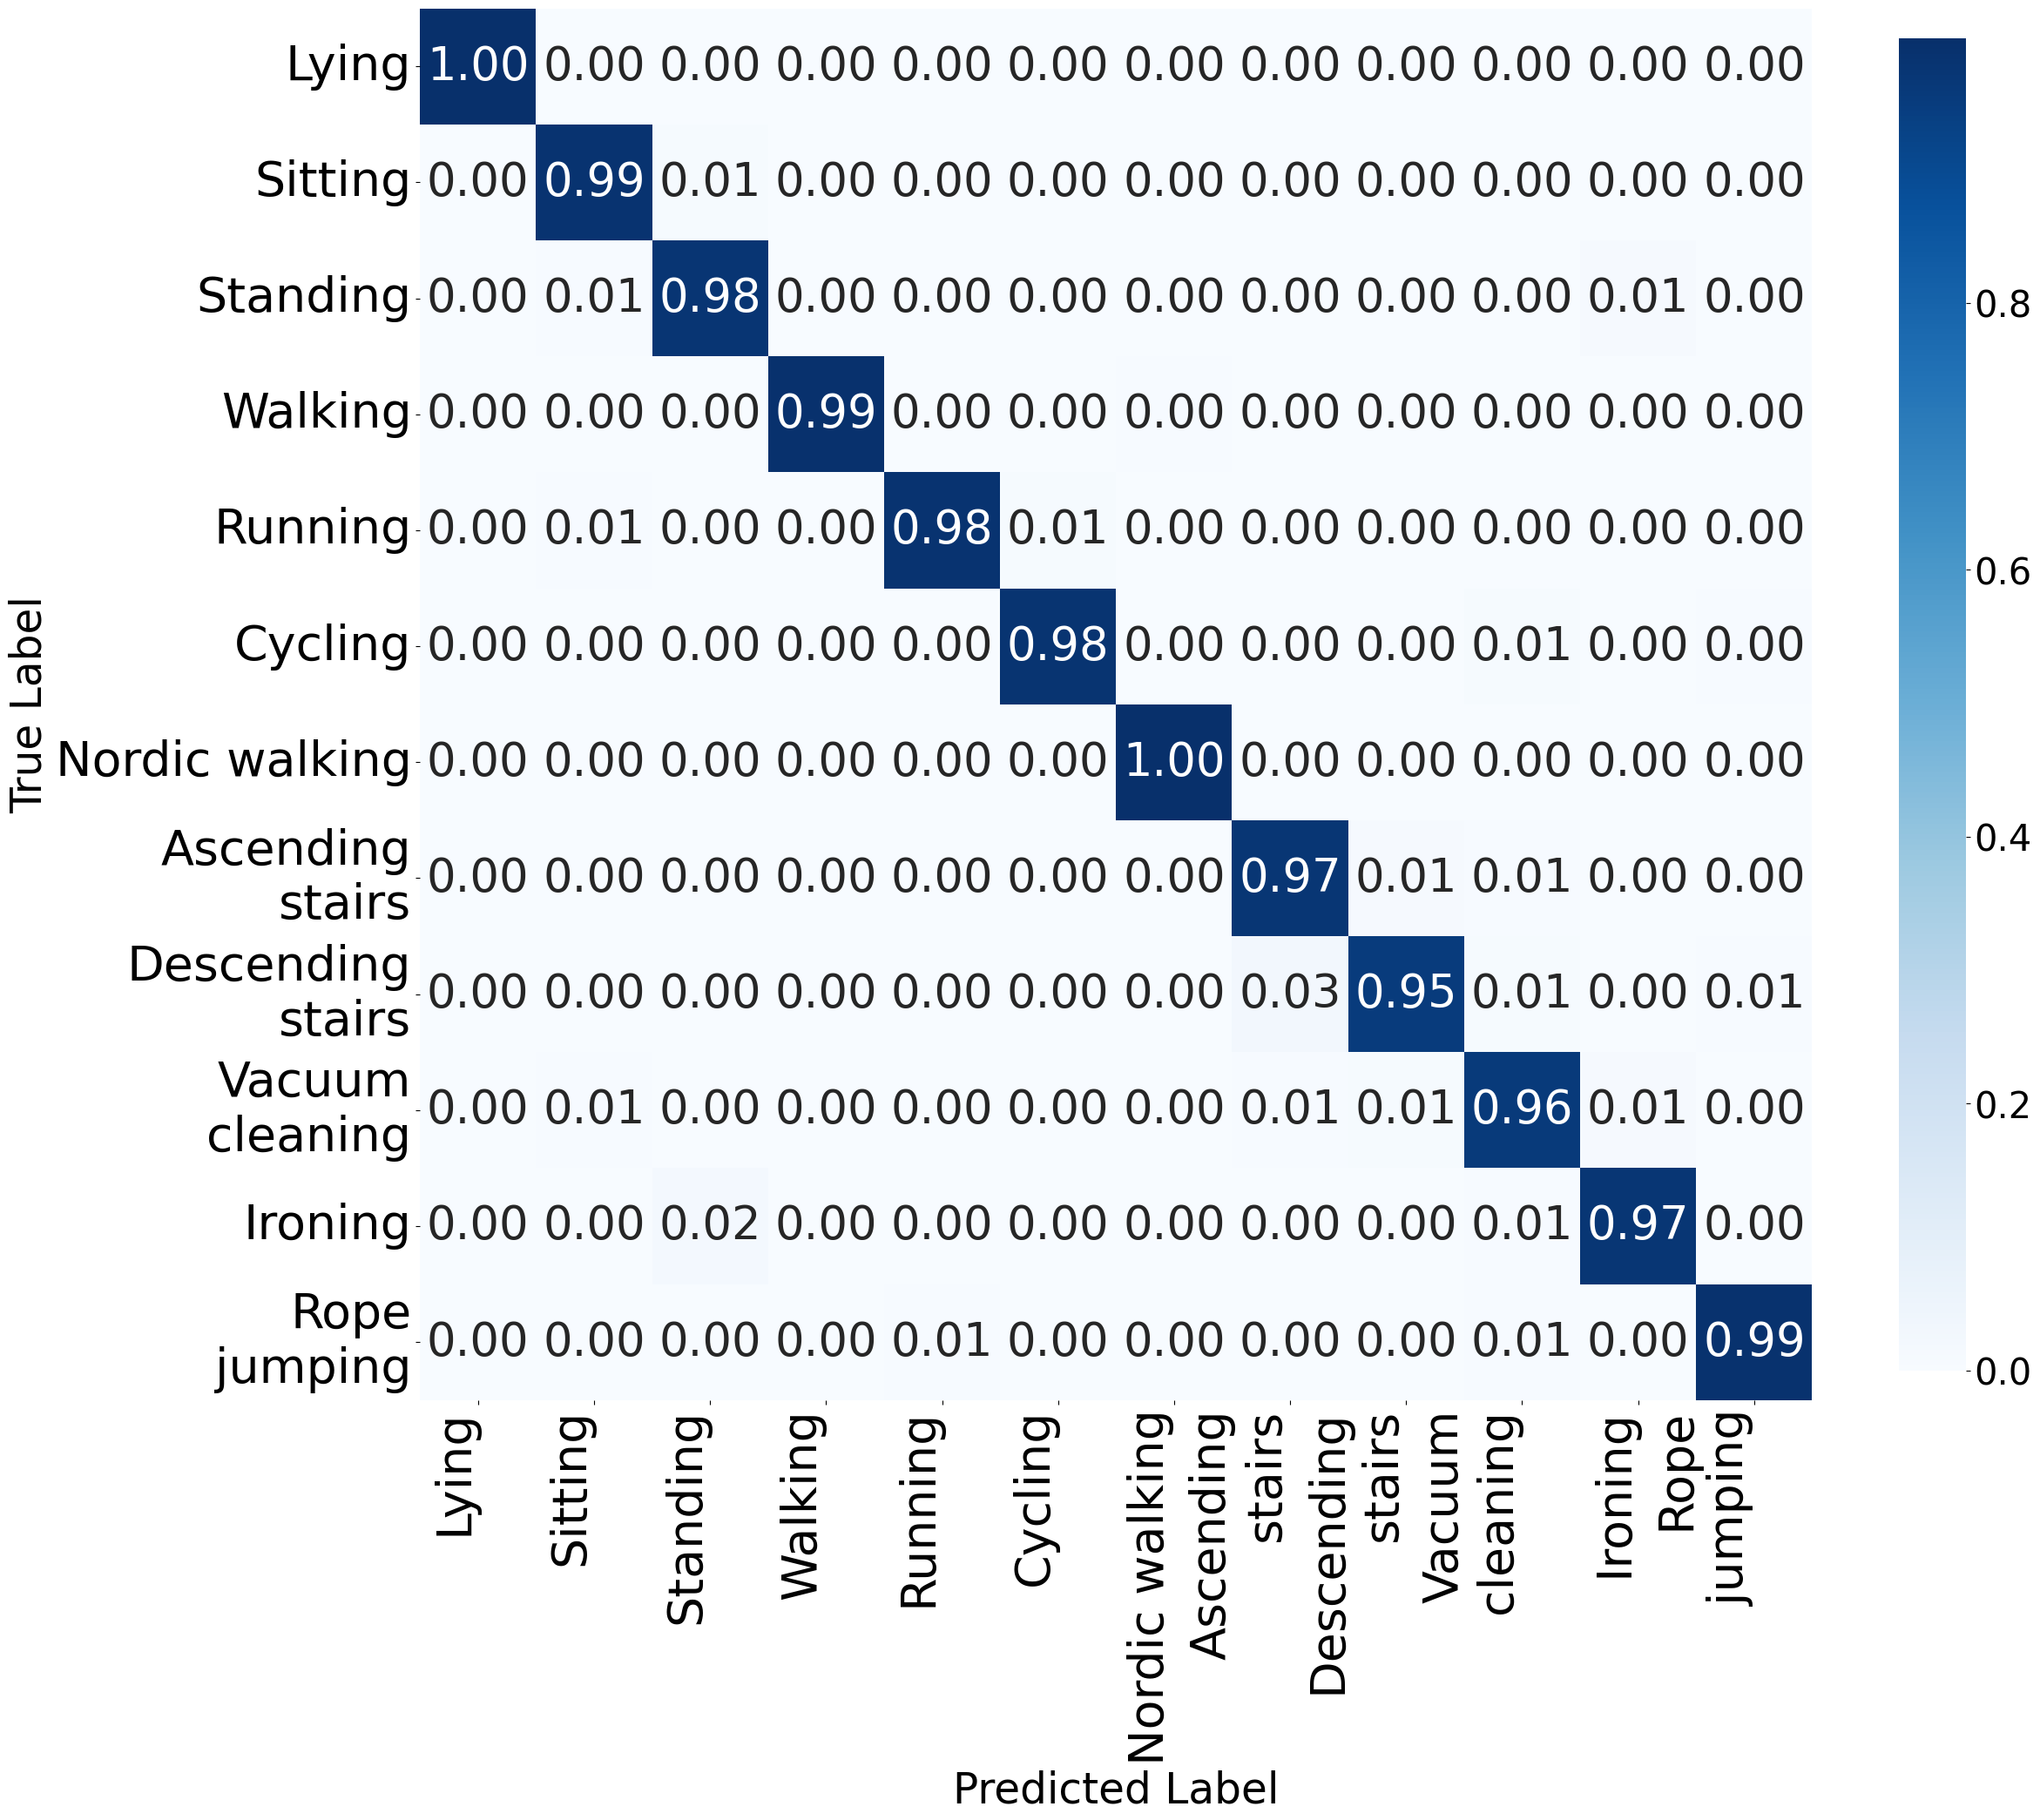


Generating t-SNE visualization (MODEL FEATURE)...


Extracting features for t-SNE: 100%|██████████| 48/48 [00:00<00:00, 102.76it/s]


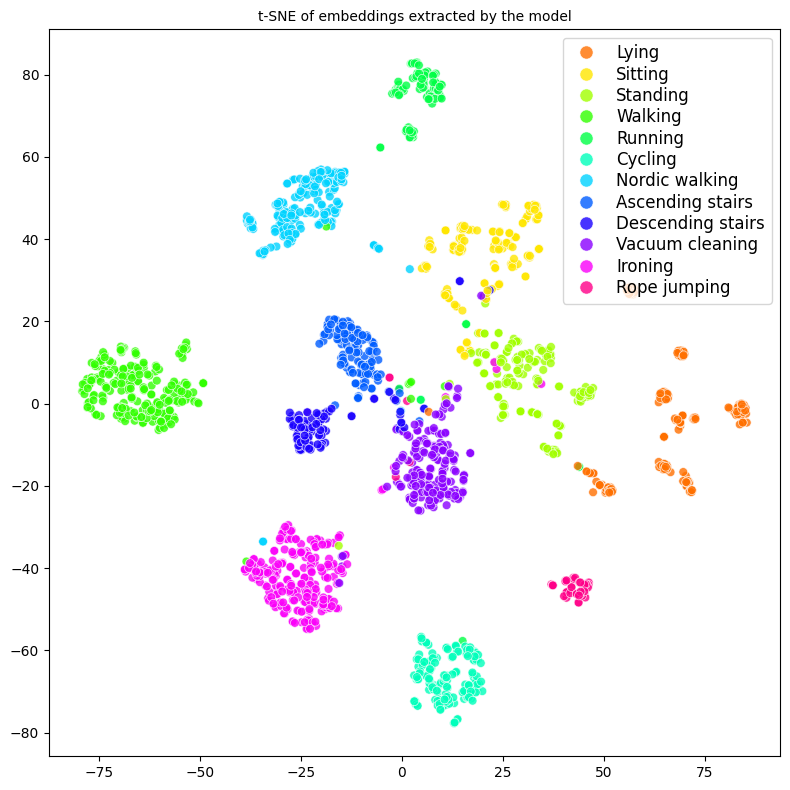


Generating t-SNE visualization (RAW INPUT)...


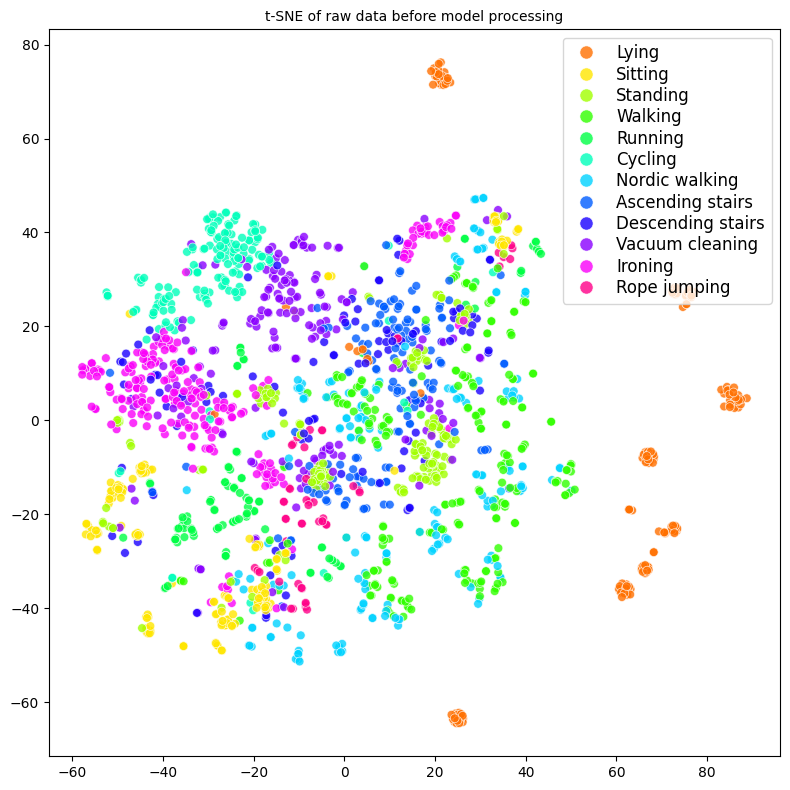

In [14]:
# =====================================================================
# 5. Main
# =====================================================================
def main():
    # -----------------------------
    # Device / SEED
    # -----------------------------
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed_everything(CONFIG["seed"])

    print("=" * 80)
    print("DataSet : PAMAP2")
    print(f"Device : {DEVICE}")
    print("=" * 80)
    pretty_print_config(CONFIG)

    # -----------------------------
    # Load DataSet
    # -----------------------------
    full_dataset = PAMAP2Dataset(
        data_dir=CONFIG["data_dir"],
        window_size=CONFIG["window_size"],
        step_size=CONFIG["step_size"],
    )

    # label_names (for CM / t-SNE legend later)
    label_names = full_dataset.label_names

    # PAMAP2 실제 데이터 기반으로 CONFIG 업데이트
    CONFIG["in_channels"]   = full_dataset.X.shape[1]          # (N, C, T)
    CONFIG["seq_len"]       = full_dataset.X.shape[2]          # window_size == T
    CONFIG["n_classes"]     = len(full_dataset.label_names)    # 보통 12
    CONFIG["n_prototypes"]  = CONFIG["n_classes"]

    # -----------------------------
    # Random split (window-level)
    #   60% train / 20% val / 20% test
    # -----------------------------
    N = len(full_dataset)
    all_indices = np.arange(N)

    rng = np.random.default_rng(CONFIG["seed"])
    rng.shuffle(all_indices)

    n_train = int(0.6 * N)
    n_val   = int(0.2 * N)
    # 나머지 전부 test
    train_idx = all_indices[:n_train]
    val_idx   = all_indices[n_train:n_train + n_val]
    test_idx  = all_indices[n_train + n_val:]

    train_dataset = Subset(full_dataset, train_idx)
    val_dataset   = Subset(full_dataset, val_idx)
    test_dataset  = Subset(full_dataset, test_idx)

    print(f"#windows total={N} | "
          f"train={len(train_dataset)}, val={len(val_dataset)}, test={len(test_dataset)}")

    # -----------------------------
    # DataLoader
    # -----------------------------
    g = torch.Generator().manual_seed(CONFIG["seed"])

    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG["batch_size"],
        shuffle=True,
        worker_init_fn=seed_worker,
        generator=g,
        num_workers=0,
        pin_memory=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG["batch_size"],
        shuffle=False,
        worker_init_fn=seed_worker,
        num_workers=0,
        pin_memory=True,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=CONFIG["batch_size"],
        shuffle=False,
        worker_init_fn=seed_worker,
        num_workers=0,
        pin_memory=True,
    )

    # -----------------------------
    # Initialize Prototypes
    # -----------------------------
    initial_prototypes = get_mean_prototypes(
        train_dataset,
        DEVICE,
        CONFIG
    )

    # -----------------------------
    # Create Model
    # -----------------------------
    model = ContrastCrossFormerCBAM_HAR(
        in_channels=CONFIG["in_channels"],
        seq_len=CONFIG["seq_len"],
        embed_dim=CONFIG["embed_dim"],
        reduced_dim=CONFIG["reduced_dim"],
        n_classes=CONFIG["n_classes"],
        n_prototypes=CONFIG["n_prototypes"],
        n_heads=CONFIG["n_heads"],
        kernel_size=CONFIG["kernel_size"],
        dropout=CONFIG["dropout"],
        temperature=CONFIG["temperature"],
        initial_prototypes=initial_prototypes,  # mean proto init
        use_cbam=CONFIG["use_cbam"],
        use_crossformer=CONFIG["use_crossformer"],
        use_contrast=CONFIG["use_contrast"],
        use_dim_reduction=CONFIG["use_dim_reduction"],
    ).to(DEVICE)

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Parameters: {total_params:,}")
    print("=" * 80)

    # -----------------------------
    # optimizer / scheduler / criterion
    # -----------------------------
    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=CONFIG["learning_rate"],
        weight_decay=CONFIG["weight_decay"],
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=CONFIG["scheduler_T_max"],
    )

    # -----------------------------
    # Train Loop
    # -----------------------------
    best_val_acc = -1.0
    best_epoch = -1
    best_state = None

    history = []
    
    for epoch in range(CONFIG["epochs"]):
        # 1) train
        train_total, train_ce, train_ct, train_acc, train_f1 = train_epoch(
            model,
            train_loader,
            criterion,
            optimizer,
            DEVICE,
            use_contrast=CONFIG["use_contrast"],
            contrast_weight=CONFIG["contrast_weight"],
        )

        # 2) val  
        val_total, val_acc, val_f1, _, _, val_ce, val_ct = evaluate(
            model,
            val_loader,
            criterion,
            DEVICE,
            use_contrast=CONFIG["use_contrast"],
            contrast_weight=CONFIG["contrast_weight"],
        )

        # 3) scheduler step
        if scheduler is not None:
            scheduler.step()

        # 4) 기록
        history.append({
            "epoch": epoch + 1,
            "train_total": train_total,
            "train_ce": train_ce,
            "train_ct": train_ct,
            "train_acc": train_acc,
            "train_f1": train_f1,
            "val_total": val_total,
            "val_ce": val_ce,
            "val_ct": val_ct,
            "val_acc": val_acc,
            "val_f1": val_f1,
        })

        # 5) best ckpt 추적 (val acc 기준)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            best_state = copy.deepcopy(model.state_dict())

        # 6) 로깅 (print_every 기준)
        if (epoch + 1) % CONFIG["print_every"] == 0:
            ep_now   = epoch + 1
            ep_total = CONFIG["epochs"]

            print(f"[{ep_now:03d}/{ep_total:03d}]")
            print(
                "  train | "
                f"total={train_total:.4f}  "
                f"ce={train_ce:.4f}  "
                f"ct={train_ct:.4f}  "
                f"acc={train_acc:.4f}  "
                f"f1={train_f1:.4f}"
            )
            print(
                "  val   | "
                f"total={val_total:.4f}  "
                f"ce={val_ce:.4f}  "
                f"ct={val_ct:.4f}  "
                f"acc={val_acc:.4f}  "
                f"f1={val_f1:.4f}"
            )

    # -------------------------------------------------
    # Load Best ckpt 
    # -------------------------------------------------
    assert best_state is not None, "Training loop didn't save any best_state."
    model.load_state_dict(best_state)

    # -------------------------------------------------
    # Final Test by Best ckpt
    # -------------------------------------------------
    test_total, test_acc, test_f1, test_preds, test_labels, test_ce, test_ct = evaluate(
        model,
        test_loader,
        criterion,
        DEVICE,
        use_contrast=CONFIG["use_contrast"],
        contrast_weight=CONFIG["contrast_weight"],
    )

    print("=" * 80)
    print("\n[Training Complete!]")
    print(f"  Best Val Acc: {best_val_acc:.4f} @ epoch {best_epoch}")
    print(
        f"  Test (best val ckpt): "
        f"acc={test_acc:.4f}, f1={test_f1:.4f}, "
        f"total_loss={test_total:.4f}, ce={test_ce:.4f}, ct={test_ct:.4f}"
    )
    
    label_names = full_dataset.label_names

    # -----------------------------
    # model profile
    # -----------------------------
    if CONFIG["profile_model"]:
        dummy_input = torch.randn(
            1,
            CONFIG["in_channels"],
            CONFIG["seq_len"],
        )
        stats = profile_model(model, dummy_input, DEVICE)
        print("==== Model Profile ====")
        print(f"Parameters      : {stats['params_m']:.4f} M")
        print(f"FLOPs / sample : {stats['flops_m']}")
        print(f"Infer Time     : {stats['inference_ms']:.2f} ms/sample")
        print("=======================")

    # -----------------------------
    # Visualize CM, t-SNE
    # -----------------------------
    plot_classification_results(
        test_labels,
        test_preds,
        label_names=label_names,
        save_path="confusion_matrix.png",
    )

    if CONFIG["do_tsne"]:
        visualize_tsne(
            model,
            test_loader,
            DEVICE,
            label_names=label_names,
            save_path="tsne_feature.png",
        )

        visualize_tsne_raw(
            test_loader,
            DEVICE,
            label_names=label_names,
            save_path="tsne_raw.png",
        )


if __name__ == "__main__":
    main()